This program will take the player's top 100 best plays and plot the year
the map was ranked and how much raw pp it gave the player

Add your USER and PASSWORD from your profile variable to get access to the APIs called below. Use the UID(s) you want to look up and run each block


In [1]:
import json
import urllib.parse
import urllib.request
import urllib.error
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests

from datetime import datetime


In [3]:
#Insert your own API key here
USER = 'PLACEHOLDER'
PASSWORD = 'PLACEHOLDER'


In [4]:
class ApiType(Enum):
    player = 1
    beatmap = 2
    other = 3


In [5]:
class Token(object):
    def __init__(self, json:json):
        self.token_type = json['token_type']
        self.token_value = json['access_token']

def get_access_token():
    
    token = requests.post('https://osu.ppy.sh/oauth/token',
                          data={'client_id':USER,
                                'client_secret':PASSWORD,
                                'grant_type':'client_credentials',
                                'scope':'public'})

    token_json = json.loads(token.text)
    token = Token(token_json)

    return token

def close_osu_api(token:Token): #revoke token
    header = {'Authorization': '{0} {1}'.format(token.token_type, token.token_value)}
    requests.delete('https://osu.ppy.sh/api/v2/oauth/tokens/current',headers=header)


token = get_access_token()

In [6]:
#player profile
class Player(object):
    def __init__(self, user_id, token):
        self.user_id = user_id
        self.best_performance_list = self.update_player_best_performance_list(token)
        self.username = self.best_performance_list[0].get_player_username()

    def update_player_best_performance_list(self,token):
        header = {'Authorization': '{0} {1}'.format(token.token_type, token.token_value)}
        best_performance_list = []
        url = url_maker(user_id,ApiType.player,"0")
        response = requests.get(url, headers=header)
        if response != None and response.status_code == 200:
            for individual_play_json in json.loads(response.text):
                best_performance_list.append(Beatmap(individual_play_json, token))
                
        url = url_maker(user_id,ApiType.player,"100") #redundant with above. Check if this works before merging
        response = requests.get(url, headers=header)
        if response != None and response.status_code == 200:
            for individual_play_json in json.loads(response.text):
                best_performance_list.append(Beatmap(individual_play_json, token))         

        print(len(best_performance_list))
        return best_performance_list

    def get_player_best_performances(self):
        return self.best_performance_list

    def get_player_username(self):
        return self.username

In [7]:
#get all the person's top plays
class Beatmap(object):
    def __init__(self, json:json, token:Token):#json of the specific best performance
        self.beatmap_name = json["beatmapset"]["artist"]
        self.beatmap_id = json["beatmap"]["id"]
        self.version = json["beatmap"]["version"] #difficulty name
        self.pp = json["pp"]
        self.username = json["user"]["username"]

        self.beatmap_ranked_date = self.set_beatmap_ranked_date(token, self.beatmap_id)

    def set_beatmap_information(self): #I forgot why I'm using this
        pass
    
    def set_beatmap_ranked_date(self, token, beatmap_id:str):
        url = url_maker(beatmap_id,ApiType.beatmap)
        header = {'Authorization': '{0} {1}'.format(token.token_type, token.token_value)}
        response = requests.get(url, headers=header)
        if response != None and response.status_code == 200:
            return json.loads(response.text)["beatmapset"]["ranked_date"]

    def get_beatmap_ranked_date(self):
        return self.beatmap_ranked_date

    def get_pp(self):
        return self.pp

    def get_player_username(self):
        return self.username
        

In [8]:
def url_maker(item_id, api_type, offset = ""):
    match api_type:
        case ApiType.player:
            return "https://osu.ppy.sh/api/v2/users/{0}/scores/best?limit=100&offset={1}".format(item_id, offset)
        case ApiType.beatmap:
            return "https://osu.ppy.sh/api/v2/beatmaps/{0}".format(item_id)
        case ApiType.other:
            return "other for testing"
        case _:
            print("Something happened...")
        

In [9]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

def get_beatmap_ranked_date(beatmap_id:str, token:Token):
    url = url_maker(beatmap_id,ApiType.beatmap)
    header = {'Authorization': '{0} {1}'.format(token.token_type, token.token_value)}
    response = requests.get(url, headers=header)
    if response != None and response.status_code == 200:
        return json.loads(response.text)["beatmapset"]["ranked_date"]

#so we can get a mindate on x axis (first ranked map: Disco Prince)
mindate = np.datetime64(get_beatmap_ranked_date("75",token),"M") 


#warning shown below refers to numpy.datetime64, however it seems that it actually won't be deprecated, but they
#kept the warning anyways. Ignore it basically


C:\Users\kcyam\AppData\Local\Temp\ipykernel_21920\3661870194.py:13: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  mindate = np.datetime64(get_beatmap_ranked_date("75",token),"M")


200


C:\Users\kcyam\AppData\Local\Temp\ipykernel_21920\3941276503.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date = np.datetime64(play.get_beatmap_ranked_date(),"M")
C:\Users\kcyam\AppData\Local\Temp\ipykernel_21920\3941276503.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(date,float(play.get_pp()),'ro',c=colors[k])
C:\Users\kcyam\AppData\Local\Temp\ipykernel_21920\3941276503.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(date,float(play.get_pp()),'ro',c=colors[k],label=name)


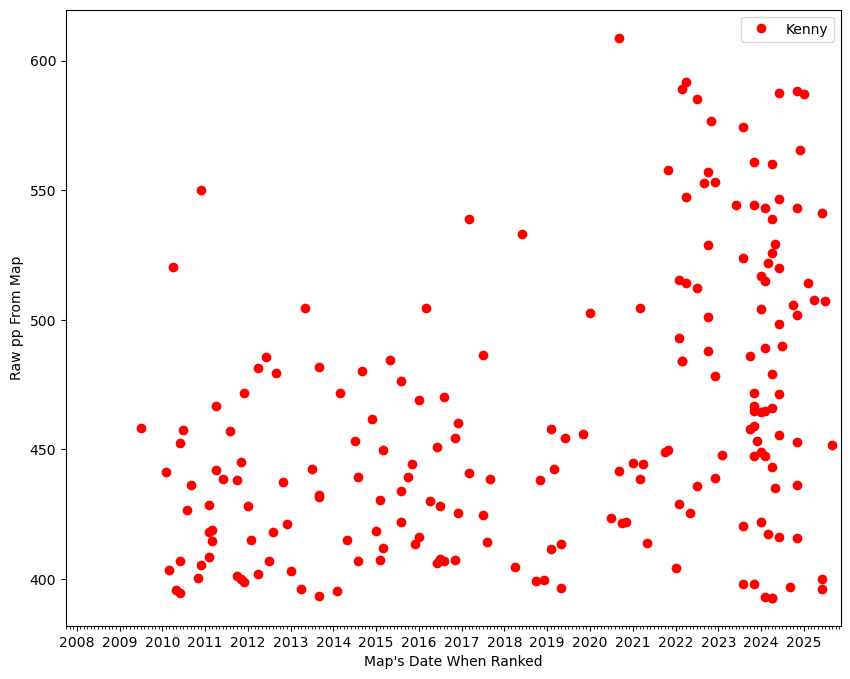

In [10]:
#Insert list of player's ID here
user_ids = [1225459]
colors = ["red","black","green","purple","yellow","blue","pink"]

plays = dict()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_xlim(mindate, datetime.now())

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
plt.xlabel("Map's Date When Ranked")
plt.ylabel("Raw pp From Map")

player_set = set()



for k, user_id in enumerate(user_ids):
    player_obj = Player(user_id, token)
    player_set.add(player_obj) #unused for now, but if I want to keep the data, it will be stored in here
    
    for play in player_obj.get_player_best_performances():
        date = np.datetime64(play.get_beatmap_ranked_date(),"M") 
        plt.plot(date,float(play.get_pp()),'ro',c=colors[k])
    #lame way to make a legend only have one
    name = player_obj.get_player_username()
    plt.plot(date,float(play.get_pp()),'ro',c=colors[k],label=name)

        
plt.legend(prop={'size': 10})

plt.show()